In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time

from collections import defaultdict

import os

In [2]:
import pandas as pd

def compare_graph_lists(true_graphs, pred_graphs):
    """
    Compare two lists of graphs and compute various metrics.
    
    Args:
        true_graphs: List of ground truth graphs
        pred_graphs: List of predicted graphs (must be same length as true_graphs)
        
    Returns:
        pandas.DataFrame with comparison metrics
    """
    if len(true_graphs) != len(pred_graphs):
        raise ValueError("Input lists must have the same length")
    
    # Initialize counters
    metrics = defaultdict(int)
    
    for true_g, pred_g in zip(true_graphs, pred_graphs):
        # Get all unique edges from both graphs
        all_edges = set(true_g.edges()).union(set(pred_g.edges()))
        
        for edge in all_edges:
            # True positive: edge exists in both
            if edge in true_g.edges() and edge in pred_g.edges():
                metrics['tp'] += 1
            # False positive: edge in pred but not in true
            elif edge not in true_g.edges() and edge in pred_g.edges():
                metrics['fp'] += 1
            # False negative: edge in true but not in pred
            elif edge in true_g.edges() and edge not in pred_g.edges():
                metrics['fn'] += 1
            # True negative: edge not in either (handled differently)
    
    # Calculate true negatives (all possible edges minus the ones we've considered)
    # This assumes we know the possible nodes - here I'll use nodes present in either graph
    all_nodes = set()
    for true_g, pred_g in zip(true_graphs, pred_graphs):
        all_nodes.update(true_g.nodes())
        all_nodes.update(pred_g.nodes())
    
    n_nodes = len(all_nodes)
    max_possible_edges = n_nodes * (n_nodes - 1)  # assuming directed graphs
    # For undirected graphs: n_nodes * (n_nodes - 1) / 2
    
    metrics['tn'] = max_possible_edges - (metrics['tp'] + metrics['fp'] + metrics['fn'])
    
    # Calculate derived metrics
    try:
        metrics['accuracy'] = (metrics['tp'] + metrics['tn']) / (metrics['tp'] + metrics['tn'] + metrics['fp'] + metrics['fn'])
    except ZeroDivisionError:
        metrics['accuracy'] = 0.0
        
    try:
        metrics['precision'] = metrics['tp'] / (metrics['tp'] + metrics['fp'])
    except ZeroDivisionError:
        metrics['precision'] = 0.0
        
    try:
        metrics['recall'] = metrics['tp'] / (metrics['tp'] + metrics['fn'])
    except ZeroDivisionError:
        metrics['recall'] = 0.0
        
    try:
        metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])
    except ZeroDivisionError:
        metrics['f1_score'] = 0.0
        
    try:
        metrics['false_positive_rate'] = metrics['fp'] / (metrics['fp'] + metrics['tn'])
    except ZeroDivisionError:
        metrics['false_positive_rate'] = 0.0
        
    try:
        metrics['false_negative_rate'] = metrics['fn'] / (metrics['fn'] + metrics['tp'])
    except ZeroDivisionError:
        metrics['false_negative_rate'] = 0.0
    
    # Create dataframe
    df = pd.DataFrame([metrics])
    df = df[['tp', 'fp', 'tn', 'fn', 
             'false_positive_rate', 'false_negative_rate',
             'accuracy', 'precision', 'recall', 'f1_score']]
    
    return df

In [3]:
def true_graph(module_num):
    j=module_num
    nodes = pd.read_csv("./EM_communities/averageSubComm%d_drosophilia.csv"%j).Node.to_list()
    
    # EM network for Module j
    
    df = pd.read_csv("traced-total-connections.csv")
    nodeA_list = df.bodyId_pre.tolist()
    nodeB_list = df.bodyId_post.tolist()
    weight_list = df.weight.tolist()
    
    # creating an edge list from adjacency matrix
    edge_list=[]
    for l,m,w in zip(nodeA_list, nodeB_list, weight_list):
        if (l in nodes) and (m in nodes):
            edge_list.append( (l,m,{"weight":w}))
    
    G_EM = nx.DiGraph()
    
    # Add all the nodes to the graph
    G_EM.add_nodes_from(nodes)
    # Add all the edges to the graph
    G_EM.add_edges_from(edge_list)
    
    return G_EM

In [4]:
def pred_graph(module_num, pr):
    j=module_num
    path = "./janelia_Comm%d/"%j
    nodes = pd.read_csv("./EM_communities/averageSubComm%d_drosophilia.csv"%j).Node.to_list()
    df_network = pd.read_csv(path+"network_%.1fum.txt"%pr, sep="\t", header=None)
    df_network = df_network.rename(columns={0: "bodyId_pre", 1: "bodyId_post", 2:"weight"})
    
    nodeA_list = df_network.bodyId_pre.tolist()
    nodeB_list = df_network.bodyId_post.tolist()
    weight_list = df_network.weight.tolist()
    
    # creating an edge list from adjacency matrix
    edge_list=[]
    for l,m,w in zip(nodeA_list, nodeB_list, weight_list):
        if (l in nodes) and (m in nodes):
            edge_list.append( (l,m,{"weight":w}))
        
    G_strah = nx.DiGraph()
    
    # Add all the nodes to the graph
    G_strah.add_nodes_from(nodes)
    # Add all the edges to the graph
    G_strah.add_edges_from(edge_list)
    return G_strah


In [5]:
results_path = "./precisionRecall_f1score_results/"
if not os.path.isdir(results_path):
    os.mkdir(results_path)

In [6]:
%%time
# proximity range 5um
for pr in [1,5]:
    print("pr =", pr)
    
    metrics={}
    metrics["Module"]=[]
    metrics['tp']=[]
    metrics['fp']=[]
    metrics['tn']=[]
    metrics['fn']=[]
    metrics['false_positive_rate']=[]
    metrics['false_negative_rate']=[]
    metrics['accuracy']=[]
    metrics['precision']=[]
    metrics['recall']=[]
    metrics['f1_score']=[]
    
        
    for module_num in range(8):
        print("Mod %d"%(module_num+1))
        metrics['Module'].append(module_num+1)
        
        true_g = true_graph(module_num)
        pred_g = pred_graph(module_num, pr)
        
        all_edges = set(true_g.edges()).union(set(pred_g.edges()))
    
        tp, fp, fn = 0,0,0
        for edge in all_edges:
            # True positive: edge exists in both
            if edge in true_g.edges() and edge in pred_g.edges():
                #metrics['tp'] += 1
                tp+=1
            # False positive: edge in pred but not in true
            elif edge not in true_g.edges() and edge in pred_g.edges():
                #metrics['fp'] += 1
                fp+=1
            # False negative: edge in true but not in pred
            elif edge in true_g.edges() and edge not in pred_g.edges():
                #metrics['fn'] += 1
                fn+=1
            # True negative: edge not in either (handled differently)
    
        # Calculate true negatives (all possible edges minus the ones we've considered)
        # This assumes we know the possible nodes - here I'll use nodes present in either graph
        all_nodes = set()
        all_nodes.update(true_g.nodes())
        all_nodes.update(pred_g.nodes())
    
        n_nodes = len(all_nodes)
        max_possible_edges = n_nodes * (n_nodes - 1)  # assuming directed graphs
        # For undirected graphs: n_nodes * (n_nodes - 1) / 2
        
        #metrics['tn'] = max_possible_edges - (metrics['tp'] + metrics['fp'] + metrics['fn'])
        tn = max_possible_edges - (tp + fp + fn)
    
        metrics['tp'].append(tp)
        metrics['fp'].append(fp)
        metrics['tn'].append(tn)
        metrics['fn'].append(fn)
    
        # Calculate derived metrics
        try:
            accuracy = (tp + tn) / (tp+tn+fp+fn)
        except ZeroDivisionError:
            accuracy = 0.0
        metrics['accuracy'].append(accuracy)
        
        try:
            precision = tp / (tp + fp)
        except ZeroDivisionError:
            precision = 0.0
        metrics['precision'].append(precision)
        
        try:
            recall = tp / (tp + fn)
        except ZeroDivisionError:
            recall = 0.0
        metrics['recall'].append(recall)
            
        try:
            f1_score = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            f1_score = 0.0
        metrics['f1_score'].append(f1_score)
            
        try:
            false_positive_rate = fp / (fp + tn)
        except ZeroDivisionError:
            false_positive_rate = 0.0
        metrics['false_positive_rate'].append(false_positive_rate)
        
        try:
            false_negative_rate = fn/(fn+tp)
        except ZeroDivisionError:
            false_negative_rate = 0.0
        metrics['false_negative_rate'].append(false_negative_rate)
        
    # Create dataframe
    df = pd.DataFrame(metrics)
    df.to_csv(results_path+"pr%d.csv"%pr,index=False)

pr = 1
Mod 1
Mod 2
Mod 3
Mod 4
Mod 5
Mod 6
Mod 7
Mod 8
pr = 5
Mod 1
Mod 2
Mod 3
Mod 4
Mod 5
Mod 6
Mod 7
Mod 8
CPU times: user 15min 35s, sys: 3.98 s, total: 15min 39s
Wall time: 15min 39s


# Module 8 different proximity range Analysis

In [7]:
def constructGraph_model(module_num, pr, graph_path):
    
    #path = "./janelia_Comm%d/"%module_num
    nodes = pd.read_csv("./EM_communities/averageSubComm%d_drosophilia.csv"%module_num).Node.to_list()
    
    df_network = pd.read_csv(graph_path+"network_%.1fum.txt"%pr, sep="\t", header=None)
    df_network = df_network.rename(columns={0: "bodyId_pre", 1: "bodyId_post", 2:"weight"})
    
    nodeA_list = df_network.bodyId_pre.tolist()
    nodeB_list = df_network.bodyId_post.tolist()
    weight_list = df_network.weight.tolist()
    
    # creating an edge list from adjacency matrix
    edge_list=[]
    for l,m,w in zip(nodeA_list, nodeB_list, weight_list):
        if (l in nodes) and (m in nodes):
            edge_list.append( (l,m,{"weight":w}))
        
    G_strah = nx.DiGraph()
    
    # Add all the nodes to the graph
    G_strah.add_nodes_from(nodes)
    # Add all the edges to the graph
    G_strah.add_edges_from(edge_list)
    return G_strah

In [14]:
%%time
module_num = 7 # In python it is 0-7 instead of counting from 1 to 8
graph_path = "./module_8/"
true_g = true_graph(module_num)

metrics={}
metrics["prox_range"]=[]
metrics['tp']=[]
metrics['fp']=[]
metrics['tn']=[]
metrics['fn']=[]
metrics['false_positive_rate']=[]
metrics['false_negative_rate']=[]
metrics['accuracy']=[]
metrics['precision']=[]
metrics['recall']=[]
metrics['f1_score']=[]
    
for pr in [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]:
    print("pr = ",pr)
    
    metrics["prox_range"].append(pr)
    pred_g = constructGraph_model(module_num, pr, graph_path)
    
    all_edges = set(true_g.edges()).union(set(pred_g.edges()))

    tp, fp, fn = 0,0,0
    for edge in all_edges:
        # True positive: edge exists in both
        if edge in true_g.edges() and edge in pred_g.edges():
            #metrics['tp'] += 1
            tp+=1
        # False positive: edge in pred but not in true
        elif edge not in true_g.edges() and edge in pred_g.edges():
            #metrics['fp'] += 1
            fp+=1
        # False negative: edge in true but not in pred
        elif edge in true_g.edges() and edge not in pred_g.edges():
            #metrics['fn'] += 1
            fn+=1
        # True negative: edge not in either (handled differently)

    # Calculate true negatives (all possible edges minus the ones we've considered)
    # This assumes we know the possible nodes - here I'll use nodes present in either graph
    all_nodes = set()
    all_nodes.update(true_g.nodes())
    all_nodes.update(pred_g.nodes())

    n_nodes = len(all_nodes)
    max_possible_edges = n_nodes * (n_nodes - 1)  # assuming directed graphs
    # For undirected graphs: n_nodes * (n_nodes - 1) / 2
    
    #metrics['tn'] = max_possible_edges - (metrics['tp'] + metrics['fp'] + metrics['fn'])
    tn = max_possible_edges - (tp + fp + fn)

    metrics['tp'].append(tp)
    metrics['fp'].append(fp)
    metrics['tn'].append(tn)
    metrics['fn'].append(fn)

    # Calculate derived metrics
    try:
        accuracy = (tp + tn) / (tp+tn+fp+fn)
    except ZeroDivisionError:
        accuracy = 0.0
    metrics['accuracy'].append(accuracy)
    
    try:
        precision = tp / (tp + fp)
    except ZeroDivisionError:
        precision = 0.0
    metrics['precision'].append(precision)
    
    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = 0.0
    metrics['recall'].append(recall)
        
    try:
        f1_score = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1_score = 0.0
    metrics['f1_score'].append(f1_score)
        
    try:
        false_positive_rate = fp / (fp + tn)
    except ZeroDivisionError:
        false_positive_rate = 0.0
    metrics['false_positive_rate'].append(false_positive_rate)
    
    try:
        false_negative_rate = fn/(fn+tp)
    except ZeroDivisionError:
        false_negative_rate = 0.0
    metrics['false_negative_rate'].append(false_negative_rate)
    
# Create dataframe
df = pd.DataFrame(metrics)
df.to_csv(results_path+"module8.csv",index=False)

pr =  0.2
pr =  0.4
pr =  0.6
pr =  0.8
pr =  1.0
pr =  1.2
CPU times: user 17.2 s, sys: 103 ms, total: 17.3 s
Wall time: 17.3 s


In [15]:
df

,prox_range,tp,fp,tn,fn,false_positive_rate,false_negative_rate,accuracy,precision,recall,f1_score
0,0.2,3861,2124,767492,73843,0.002760,0.950311,0.910344,0.645113,0.049689,0.092270
1,0.4,4478,3100,766516,73226,0.004028,0.942371,0.909921,0.590921,0.057629,0.105016
2,0.6,4649,3696,765920,73055,0.004802,0.940170,0.909419,0.557100,0.059830,0.108055
3,0.8,4789,4243,765373,72915,0.005513,0.938369,0.908939,0.530226,0.061631,0.110427
4,1.0,4933,4827,764789,72771,0.006272,0.936515,0.908419,0.505430,0.063485,0.112801
5,1.2,5076,5418,764198,72628,0.007040,0.934675,0.907891,0.483705,0.065325,0.115105


In [16]:
df = pd.read_csv(results_path+"module8.csv")
df

,prox_range,tp,fp,tn,fn,false_positive_rate,false_negative_rate,accuracy,precision,recall,f1_score
0,0.2,3861,2124,767492,73843,0.002760,0.950311,0.910344,0.645113,0.049689,0.092270
1,0.4,4478,3100,766516,73226,0.004028,0.942371,0.909921,0.590921,0.057629,0.105016
2,0.6,4649,3696,765920,73055,0.004802,0.940170,0.909419,0.557100,0.059830,0.108055
3,0.8,4789,4243,765373,72915,0.005513,0.938369,0.908939,0.530226,0.061631,0.110427
4,1.0,4933,4827,764789,72771,0.006272,0.936515,0.908419,0.505430,0.063485,0.112801
5,1.2,5076,5418,764198,72628,0.007040,0.934675,0.907891,0.483705,0.065325,0.115105


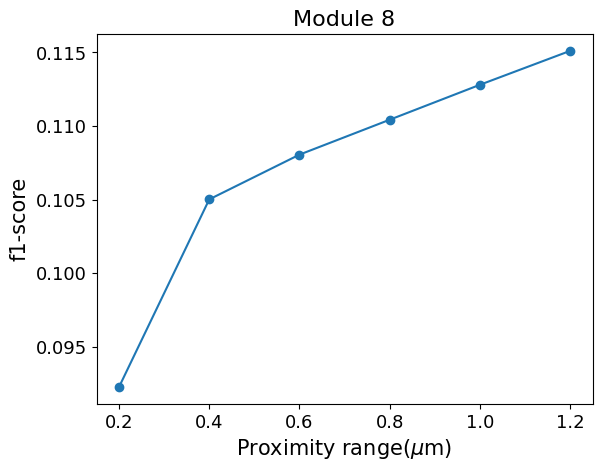

In [33]:
# Set font sizes for all plot elements
plt.rcParams.update({'font.size': 14})  # Base font size
plt.rcParams['axes.titlesize'] = 16    # Title font size
plt.rcParams['axes.labelsize'] = 15     # Axis label font size
plt.rcParams['xtick.labelsize'] = 13    # X-axis tick label size
plt.rcParams['ytick.labelsize'] = 13    # Y-axis tick label size

plt.plot(df['prox_range'], df['f1_score'], "o-")

plt.xlabel("Proximity range($\mu$m)")
plt.ylabel("f1-score")
plt.title("Module 8")
    
plt.savefig(results_path+"module8_f1_score.pdf",
            facecolor="white", bbox_inches="tight", dpi=600)


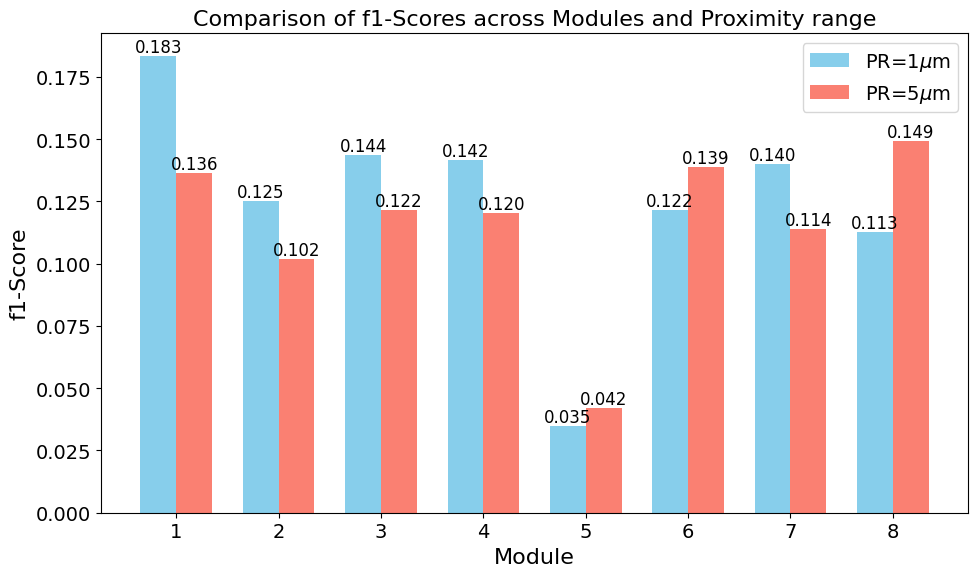

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
pr1 = pd.read_csv('./precisionRecall_f1score_results/pr1.csv')
pr5 = pd.read_csv('./precisionRecall_f1score_results/pr5.csv')

# Set up the plot
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 14})  # Increase base font size
plt.rcParams['axes.titlesize'] = 16    # Title font size
plt.rcParams['axes.labelsize'] = 16     # Axis label font size
plt.rcParams['xtick.labelsize'] = 14    # X-axis tick label size
plt.rcParams['ytick.labelsize'] = 14    # Y-axis tick label size

# Set width of each bar
bar_width = 0.35

# Create positions for the bars
x = np.arange(len(pr1['Module']))
x1 = x - bar_width/2
x2 = x + bar_width/2

# Create the bars
plt.bar(x1, pr1['f1_score'], width=bar_width, label='PR=1$\mu$m', color='skyblue')
plt.bar(x2, pr5['f1_score'], width=bar_width, label='PR=5$\mu$m', color='salmon')

# Customize the plot
plt.xlabel('Module', fontsize=16)
plt.ylabel('f1-Score', fontsize=16)
plt.title('Comparison of f1-Scores across Modules and Proximity range', fontsize=16)
plt.xticks(x, np.array(pr1['Module'])+1)
plt.legend()

# Add value labels on top of each bar
for i in range(len(pr1['Module'])):
    plt.text(x1[i], pr1['f1_score'][i], f'{pr1["f1_score"][i]:.3f}', 
             ha='center', va='bottom', fontsize=12)
    plt.text(x2[i], pr5['f1_score'][i], f'{pr5["f1_score"][i]:.3f}', 
             ha='center', va='bottom', fontsize=12)

# Adjust layout and show
plt.tight_layout()
plt.savefig(results_path+"f1_score.pdf",
            facecolor="white", bbox_inches="tight", dpi=600)

plt.show()